## Stable Model Training

#### NOTES:  
* This is "NoGAN" based training, described in the DeOldify readme.
* This model prioritizes stable and reliable renderings.  It does particularly well on portraits and landscapes.  It's not as colorful as the artistic model.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1' 

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks.tensorboard import *
from fastai.vision.gan import *
from fasterai.generators import *
from fasterai.critics import *
from fasterai.dataset import *
from fasterai.loss import *
from fasterai.save import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile

## Setup

In [3]:
path = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
path_hr = path
path_lr = path/'bandw'

proj_id = 'StableModel'

gen_name = proj_id + '_gen'
pre_gen_name = gen_name + '_0'
crit_name = proj_id + '_crit'

name_gen = proj_id + '_image_gen'
path_gen = path/name_gen

TENSORBOARD_PATH = Path('data/tensorboard/' + proj_id)

nf_factor = 2
pct_start = 1e-8

In [4]:
def get_data(bs:int, sz:int, keep_pct:float):
    return get_colorize_data(sz=sz, bs=bs, crappy_path=path_lr, good_path=path_hr, 
                             random_seed=None, keep_pct=keep_pct)

def get_crit_data(classes, bs, sz):
    src = ImageList.from_folder(path, include=classes, recurse=True).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=sz)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

def create_training_images(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn).convert('LA').convert('RGB')
    img.save(dest)  
    
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
    
def save_gen_images():
    if path_gen.exists(): shutil.rmtree(path_gen)
    path_gen.mkdir(exist_ok=True)
    data_gen = get_data(bs=bs, sz=sz, keep_pct=0.085)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(path_gen.ls()[0])

## Create black and white training images

Only runs if the directory isn't already created.

In [5]:
if not path_lr.exists():
    il = ImageList.from_folder(path_hr)
    parallel(create_training_images, il.items)

/opt/conda/lib/python3.6/site-packages/fastprogress/fastprogress.py:102: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


## Pre-train generator

#### NOTE
Most of the training takes place here in pretraining for NoGAN.  The goal here is to take the generator as far as possible with conventional training, as that is much easier to control and obtain glitch-free results compared to GAN training.

### 64px

In [6]:
bs=88
sz=64
keep_pct=1.0

In [7]:
data_gen = get_data(bs=bs, sz=sz, keep_pct=keep_pct)

IndexError: index 0 is out of bounds for axis 1 with size 0

In [8]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor)

In [9]:
learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPre'))

In [11]:
learn_gen.fit_one_cycle(1, pct_start=0.8, max_lr=slice(1e-3))

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE
/opt/conda/lib/python3.6/site-packages/torch/onnx/utils.py:501: UserWarning: ONNX export failed on ATen operator reshape because torch.onnx.symbolic.reshape does not exist
  .format(op_name, op_name))
/opt/conda/lib/python3.6/site-packages/torch/onnx/utils.py:501: UserWarning: ONNX export failed on ATen operator mv because torch.onnx.symbolic.mv does not exist
  .format(op_name, op_name))
/opt/conda/lib/python3.6/site-packages/torch/onnx/utils.py:501: UserWarning: ONNX export failed on ATen operator dot because torch.onnx.symbolic.dot does not exist
  .format(op_name, op_name))


epoch,train_loss,valid_loss,time


/opt/conda/lib/python3.6/site-packages/torch/onnx/utils.py:501: UserWarning: ONNX export failed on ATen operator reshape because torch.onnx.symbolic.reshape does not exist
  .format(op_name, op_name))
/opt/conda/lib/python3.6/site-packages/torch/onnx/utils.py:501: UserWarning: ONNX export failed on ATen operator mv because torch.onnx.symbolic.mv does not exist
  .format(op_name, op_name))
/opt/conda/lib/python3.6/site-packages/torch/onnx/utils.py:501: UserWarning: ONNX export failed on ATen operator dot because torch.onnx.symbolic.dot does not exist
  .format(op_name, op_name))
/opt/conda/lib/python3.6/site-packages/torch/onnx/symbolic.py:131: UserWarning: ONNX export failed on dim because ONNX and PyTorch use different strategies to split the input. not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


graph(%0 : Float(1, 3, 64, 64)
      %1 : Float(64, 3, 7, 7)
      %2 : Float(64)
      %3 : Float(64)
      %4 : Float(64)
      %5 : Float(64)
      %6 : Long()
      %7 : Float(64, 64, 1, 1)
      %8 : Float(64)
      %9 : Float(64)
      %10 : Float(64)
      %11 : Float(64)
      %12 : Long()
      %13 : Float(64, 64, 3, 3)
      %14 : Float(64)
      %15 : Float(64)
      %16 : Float(64)
      %17 : Float(64)
      %18 : Long()
      %19 : Float(256, 64, 1, 1)
      %20 : Float(256)
      %21 : Float(256)
      %22 : Float(256)
      %23 : Float(256)
      %24 : Long()
      %25 : Float(256, 64, 1, 1)
      %26 : Float(256)
      %27 : Float(256)
      %28 : Float(256)
      %29 : Float(256)
      %30 : Long()
      %31 : Float(64, 256, 1, 1)
      %32 : Float(64)
      %33 : Float(64)
      %34 : Float(64)
      %35 : Float(64)
      %36 : Long()
      %37 : Float(64, 64, 3, 3)
      %38 : Float(64)
      %39 : Float(64)
      %40 : Float(64)
      %41 : Float(64)
      %42 : Lo

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/fastai/callbacks/tensorboard.py", line 227, in _queue_processor
    request.write()
  File "/opt/conda/lib/python3.6/site-packages/fastai/callbacks/tensorboard.py", line 417, in write
    self.tbwriter.add_graph(model=self.model, input_to_model=self.input_to_model)
  File "/opt/conda/lib/python3.6/site-packages/tensorboardX/writer.py", line 566, in add_graph
    self.file_writer.add_graph(graph(model, input_to_model, verbose))
  File "/opt/conda/lib/python3.6/site-packages/tensorboardX/writer.py", line 107, in add_graph
    graph = graph_profile[0]
TypeError: 'GraphDef' object does not support indexing

/opt/conda/lib/python3.6/site-packages/torch/onnx/utils.py:501: UserWarni

KeyboardInterrupt: 

In [15]:
learn_gen.save(pre_gen_name)

In [16]:
learn_gen.unfreeze()

In [17]:
learn_gen.fit_one_cycle(1, pct_start=pct_start,  max_lr=slice(3e-7, 3e-4))

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,time
0,0.167366,0.147400,02:46


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [18]:
learn_gen.save(pre_gen_name)

### 128px

In [19]:
bs=20
sz=128
keep_pct=1.0

In [20]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

In [21]:
learn_gen.unfreeze()

In [22]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(1e-7,1e-4))

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,time
0,0.094008,0.085316,04:29


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [23]:
learn_gen.save(pre_gen_name)

### 192px

In [24]:
bs=8
sz=192
keep_pct=0.50

In [25]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


In [26]:
learn_gen.unfreeze()

In [27]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(5e-8,5e-5))

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,time
0,0.068586,0.062971,04:51


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [28]:
learn_gen.save(pre_gen_name)

## Repeatable GAN Cycle

#### NOTE
Best results so far have been based on repeating the cycle below a few times (about 5-8?), until diminishing returns are hit (no improvement in image quality).  Each time you repeat the cycle, you want to increment that old_checkpoint_num by 1 so that new check points don't overwrite the old.  

In [29]:
old_checkpoint_num = 0
checkpoint_num = old_checkpoint_num + 1
gen_old_checkpoint_name = gen_name + '_' + str(old_checkpoint_num)
gen_new_checkpoint_name = gen_name + '_' + str(checkpoint_num)
crit_old_checkpoint_name = crit_name + '_' + str(old_checkpoint_num)
crit_new_checkpoint_name= crit_name + '_' + str(checkpoint_num)

### Save Generated Images

In [30]:
bs=8
sz=192

In [36]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)

In [37]:
save_gen_images()

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


### Pretrain Critic

##### Only need full pretraining of critic when starting from scratch.  Otherwise, just finetune!

/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:203: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
VIS_ALIGN
  if getattr(ds, 'warn', False): warn(ds.warn)
/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
VIS_ALIGN
  if getattr(ds, 'warn', False): warn(ds.warn)
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
 

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.041659,0.000000,1.000000,00:15
1,0.012137,0.000000,1.000000,00:13
2,0.004456,0.000000,1.000000,00:14
3,0.001755,0.000000,1.000000,00:13
4,0.000709,0.000000,1.000000,00:13
5,0.000289,0.000000,1.000000,00:13


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

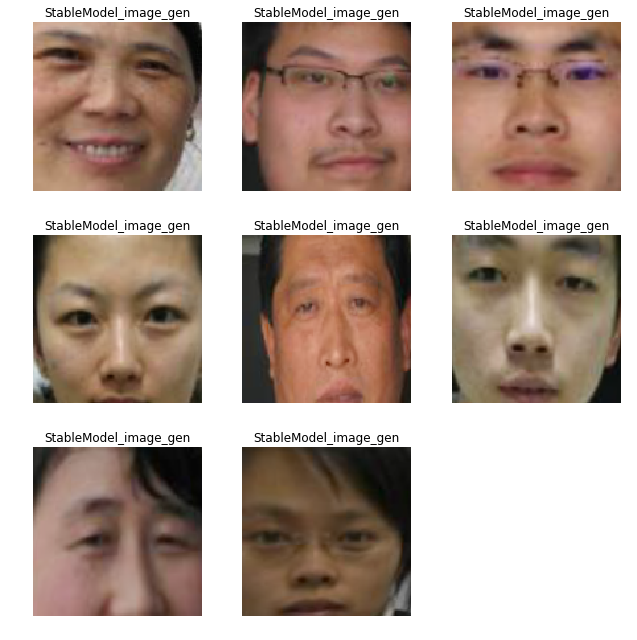

In [38]:
if old_checkpoint_num == 0:
    bs=8
    sz=128
    learn_gen=None
    gc.collect()
    data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)
    data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)
    learn_critic = colorize_crit_learner(data=data_crit, nf=256)
    learn_critic.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=TENSORBOARD_PATH, name='CriticPre'))
    learn_critic.fit_one_cycle(6, 1e-3)
    learn_critic.save(crit_old_checkpoint_name)

In [39]:
bs=16
sz=192

In [40]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)

/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:203: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
VIS_ALIGN
  if getattr(ds, 'warn', False): warn(ds.warn)
/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
VIS_ALIGN
  if getattr(ds, 'warn', False): warn(ds.warn)
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
 

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

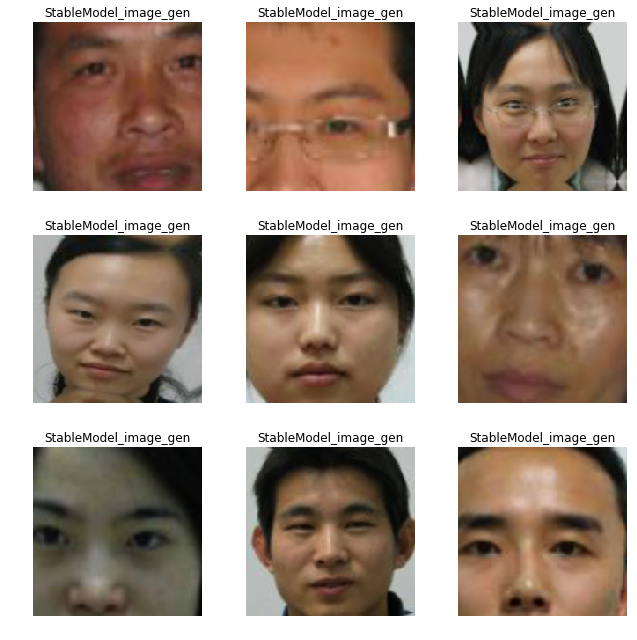

In [41]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [42]:
learn_critic = colorize_crit_learner(data=data_crit, nf=256).load(crit_old_checkpoint_name, with_opt=False)

In [43]:
learn_critic.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=TENSORBOARD_PATH, name='CriticPre'))

In [44]:
learn_critic.fit_one_cycle(4, 1e-4)

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.000000,0.000000,1.000000,00:20
1,0.000000,0.000000,1.000000,00:17
2,0.000000,0.000000,1.000000,00:16
3,0.000000,0.000000,1.000000,00:17


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [46]:
learn_critic.save(crit_new_checkpoint_name)

### GAN

In [47]:
learn_crit=None
learn_gen=None
gc.collect()

71

In [54]:
lr=2e-5
sz=192
bs=5

In [55]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)

/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:203: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
VIS_ALIGN
  if getattr(ds, 'warn', False): warn(ds.warn)
/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
VIS_ALIGN
  if getattr(ds, 'warn', False): warn(ds.warn)


In [56]:
learn_crit = colorize_crit_learner(data=data_crit, nf=256).load(crit_new_checkpoint_name, with_opt=False)

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 10.92 GiB total capacity; 10.16 GiB already allocated; 29.50 MiB free; 144.11 MiB cached)

In [51]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)

In [52]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.0,1.5), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn.callback_fns.append(partial(GANTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GanLearner', visual_iters=100))
learn.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_iters=100))

#### Instructions:  
Find the checkpoint just before where glitches start to be introduced.  This is all very new so you may need to play around with just how far you go here with keep_pct.

In [53]:
learn.data = get_data(sz=sz, bs=bs, keep_pct=0.03)
learn_gen.freeze_to(-1)
learn.fit(1,lr)

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,gen_loss,disc_loss,time


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 10.92 GiB total capacity; 10.08 GiB already allocated; 29.50 MiB free; 223.00 MiB cached)